In [1]:
import pandas as pd
!pip install razdel pymorphy2
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

!pip install pymorphy2
!pip install razdel
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize
import pymorphy2



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=a263a04cd6292fc467fe81c351a91b3138795069c1669ba150a7eda23a1fb1b6
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Загрузка данных из файла
df = pd.read_csv('/content/data.tsv', sep='\t')
df.head()

,title,score,link,summary,published,tickers
0,Электромобильный стартап Arrival экс-главы Yot...,-0.583333,https://www.rbc.ru/technology_and_media/12/05/...,"Британский электромобильный стартап Arrival, к...","Thu, 12 May 2022 05:10:01 +0300",['ARVL']
1,Экс-глава НМТП рассказал о «напряженных отноше...,-0.314286,https://www.rbc.ru/society/16/11/2020/5fb2709d...,Экс-председатель совета директоров Новороссийс...,"Fri, 20 May 2022 19:13:18 +0300",['NMTP']
2,Шрёдер отклонил предложение войти в совет дире...,-0.333333,https://www.rbc.ru/business/20/05/2022/628772b...,Его кандидатуру выдвинули в начале февраля. Ка...,"Tue, 24 May 2022 22:12:05 +0300",['GAZP']
3,Шельф берут в разработку // Генподрядчиком «Га...,0.700000,https://www.kommersant.ru/doc/5482398,"Как стало известно “Ъ”, «Аврора» Андрея Патруш...","Fri, 29 Jul 2022 00:28:00 +0300",['GAZP']
4,"Чистый убыток ""Юнипро"" в 1 полугодии 2022 года...",-0.611111,https://www.finam.ru/analysis/newsitem/chistyi...,"Чистый убыток ""Юнипро"" в 1 полугодии 2022 года...","Thu, 28 Jul 2022 12:43:00 +0300",['UPRO']


In [4]:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

--2024-07-22 11:04:43--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Resolving drive.google.com (drive.google.com)... 172.217.203.113, 172.217.203.100, 172.217.203.138, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c&export=download [following]
--2024-07-22 11:04:43--  https://drive.usercontent.google.com/download?id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.204.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5368 (5.2K) [application/octet-stream]
Saving to: ‘stopwords.txt’

stopwords.txt       100%[===================>]   5.24K  --.-KB

In [5]:
stop_words = stopwords.words('russian')
print(len(stop_words))

151


In [6]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]

stop_words += additional_stopwords
len(stop_words)

776

In [7]:
def clean_text(text):
    '''
    очистка текста

    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)

    return text

    cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords = [i for i in words_lem if not i in stop_words] # [6]

    return words_lem_without_stopwords

In [8]:
# Объединение данных из колонок 'title' и 'description'
corpus = df['title'] + ' ' + df['summary']

# Токенизация, удаление стоп-слов и лемматизация
morph = pymorphy2.MorphAnalyzer()

# Преобразование текста в нижний регистр, токенизация, удаление стоп-слов и лемматизация
tokenized_corpus = [word_tokenize(str(sentence).lower()) for sentence in corpus]

filtered_corpus = [[word for word in sentence if word.isalnum() and word not in stop_words] for sentence in tokenized_corpus]

# Удаление цифр и английских букв с помощью регулярных выражений
filtered_corpus = [[re.sub(r'[A-Za-z0-9]', '', word) for word in sentence] for sentence in filtered_corpus]

# Вывод результата
for sublist in filtered_corpus:
    print('\n'.join(sublist))

#lemmatizer = WordNetLemmatizer()
#lemmatized_corpus = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in filtered_corpus]


электромобильный
стартап


уйдет
россии
британский
электромобильный
стартап

основал
телекоммуникационного
оператора

бывший
замминистра
связи
денис
свердлов
намерен
прекратить
деятельность
россии
сообщает


нмтп
рассказал
напряженных
отношениях
братьев
магомедовых
совета
директоров
новороссийского
морского
торгового
порта
нмтп
рассказал
хамовническом
суде
напряженных
отношениях
братьями
магомедовыми
суде
рассматривают
иск
генпрокуратуры
изъятию

млн
шрёдер
отклонил
предложение
войти
совет
директоров
газпрома
кандидатуру
выдвинули
начале
февраля
пишет

шрёдер
сообщил
отказался
предложения
давно
шельф
берут
разработку
генподрядчиком
газпрома
море
андрея
патрушева
стало
известно
ъ
аврора
андрея
патрушева
новым
названием
газпром
шельфпроект
основным
подрядчиком
газпрома
бурению
шельфе
управление
перейдет
нынешний
флот
плавучих
буровых
платформ
судов
снабжения
газпром
флота
консолидировать
заказы
газпрома
новатэка
бурению
акватории
арктических
морей
газпром
шельфпроекте
заявили
ъ
рассчитыв

In [14]:
news_2014 = pd.read_csv('/content/news_2014.csv', sep=';')
news_2014.head()

,Link,Date,Source,Title,Description
0,https://www.finam.ru/publications/item/dve-tre...,2014-01-01,NaN,Две трети россиян не имеют вкладов в банках,"Большинство россиян не хранят деньги в банках,..."
1,https://www.finam.ru/publications/item/inflyac...,2014-01-01,NaN,"Инфляция в РФ в 2013 году, по предварительным ...",Инфляция в России на конец 2013 года составила...
2,https://www.finam.ru/publications/item/rossiya...,2014-01-01,NaN,"Россия начинает председательство в G8, главная...",Сейчас в мире на первый план выходит обеспечен...
3,https://www.finam.ru/publications/item/putin-o...,2014-01-01,NaN,Путин обещает продолжить борьбу с террористами...,Российский президент Владимир Путин в своем но...
4,https://www.finam.ru/publications/item/kapital...,2014-01-01,NaN,Капитала много не бывает! Сохраняйте и приумно...,NaN


In [16]:
news_2015 = pd.read_csv('/content/news_2015.csv', sep=';')
news_2015.head()

,Link,Date,Source,Title,Description
0,https://www.finam.ru/publications/item/avtovaz...,2015-01-01,NaN,"""АВТОВАЗ"": Закон о промышленной политике позво...",NaN
1,https://www.finam.ru/publications/item/ekspert...,2015-01-01,NaN,Эксперт: Принятие закона о промышленной полити...,NaN
2,https://www.finam.ru/publications/item/putin-o...,2015-01-01,NaN,Путин обязал с 1 сентября хранить персональные...,Президент России Владимир Путин подписал закон...
3,https://www.finam.ru/publications/item/pravite...,2015-01-01,NaN,"Правительство РФ выделило РЖД и ""Газпромбанку""...","Правительство РФ выделило РЖД и ""Газпромбанку""..."
4,https://www.finam.ru/publications/item/putin-p...,2015-01-01,NaN,Путин подписал закон о промышленной политике,Путин подписал закон о промышленной политике


In [17]:
news_2016 = pd.read_csv('/content/news_2016.csv', sep=';')
news_2016.head()

,Link,Date,Source,Title,Description
0,https://www.finam.ru/publications/item/zhiteli...,2016-01-01,NaN,Жители Крыма высказались против подписания кон...,"Соцопрос, проведенный по поручению президента ..."
1,https://www.finam.ru/publications/item/putin-u...,2016-01-01,NaN,Путин утвердил новую стратегию национальной бе...,Путин утвердил новую стратегию национальной бе...
2,https://www.finam.ru/publications/item/putin-p...,2016-01-01,NaN,Путин подписал указ о сокращении штата госаппа...,NaN
3,https://www.finam.ru/publications/item/putin-p...,2016-01-01,NaN,Путин подписал указ о мерах по обеспечению эко...,NaN
4,https://www.finam.ru/publications/item/minfin-...,2016-01-01,NaN,Минфин РФ констатировал дефолт Украины по долг...,Минфин РФ констатировал дефолт Украины по долг...


In [18]:
news_2017 = pd.read_csv('/content/news_2017.csv', sep=';')
news_2017.head()

,Link,Date,Source,Title,Description
0,https://www.finam.ru/publications/item/s-novym...,2017-01-01,NaN,Блестящих возможностей и перспективных проекто...,Желаем вам в новом году блестящих возможностей...
1,https://www.finam.ru/publications/item/s-novym...,2017-01-01,NaN,Восходящего тренда вам в наступившем году!,Пусть 2017 год будет успешным: профессиональны...
2,https://www.finam.ru/publications/item/kitaiy-...,2017-01-01,NaN,Китай: Индекс деловой активности в промышленно...,Китай: Индекс деловой активности в промышленно...
3,https://www.finam.ru/publications/item/s-novym...,2017-01-02,NaN,Желаем вам стабильности во всех сферах жизни!,Желаем вам стабильности во всех сферах жизни! ...
4,https://www.finam.ru/publications/item/mirovye...,2017-01-02,NaN,Мировые биржи в первый торговый день года растут,На европейских фондовых площадках в понедельни...


In [19]:
news_2018  =pd.read_csv('/content/news_2018.csv', sep=';')
news_2018.head()

,Link,Date,Source,Title,Description
0,https://www.finam.ru/publications/item/razbor-...,2018-01-01,NaN,Разбор полетов: Пять главных ИТ-сделок года,"Уважаемые дамы и господа! В разделе ""Разбор по..."
1,https://www.finam.ru/publications/item/novyiy-...,2018-01-01,NaN,Новый год уже шагает по планете! Встречайте ег...,NaN
2,https://www.finam.ru/publications/item/razbor-...,2018-01-01,NaN,Разбор полетов: Зачем нужен блокчейн и что буд...,"Уважаемые дамы и господа! В разделе ""Разбор по..."
3,https://www.finam.ru/publications/item/scenari...,2018-01-02,NaN,Сценарии и прогнозы: Выборы президента в Росси...,"Уважаемые дамы и господа! В разделе ""Сценарии ..."
4,https://www.finam.ru/publications/item/amerika...,2018-01-02,NaN,"Инвесторы верят в рост экономики США, несмотря...","3 января, в США будут опубликованы протоколы д..."


In [20]:
news_2019 = pd.read_csv('/content/news_2019.csv', sep=';')
news_2019.head()

,Link,Date,Source,Title,Description
0,https://www.finam.ru/publications/item/udachi-...,2019-01-01,NaN,Удачи в Новом году!,NaN
1,https://www.finam.ru/publications/item/scenari...,2019-01-01,NaN,Сценарии и прогнозы: Для российского рынка 201...,"Уважаемые дамы и господа! В разделе ""Сценарии ..."
2,https://www.finam.ru/publications/item/menee-a...,2019-01-01,NaN,Менее агрессивная монетарная политика пойдет н...,В 2019 году ФРС повысит ставку только два раза...
3,https://www.finam.ru/publications/item/s-novym...,2019-01-01,NaN,С Новым Годом! Пусть он будет прибыльным!,NaN
4,https://www.finam.ru/publications/item/scenari...,2019-01-01,NaN,Сценарии и прогнозы: Инвестиции в России - тре...,"Уважаемые дамы и господа! В разделе ""Сценарии ..."


In [21]:
news_2020 = pd.read_csv('/content/news_2020.csv', sep=';')
news_2020.head()

,Link,Date,Source,Title,Description
0,https://www.finam.ru/publications/item/udachi-...,2020-01-01,NaN,Удачи в Новом году!,NaN
1,https://www.finam.ru/publications/item/s-novym...,2020-01-01,NaN,С Новым Годом! Пусть он будет прибыльным!,NaN
2,https://www.finam.ru/publications/item/klyuche...,2020-01-01,NaN,Ключевые российские нефтегазовые компании смот...,Основные риски отрасли сопряжены с возможным д...
3,https://www.finam.ru/publications/item/v-2020-...,2020-01-01,NaN,Нефть Brent в 2020 году будет относительно ста...,Риски низких цен на нефть возможны в случае бо...
4,https://www.finam.ru/publications/item/novyiy-...,2020-01-01,NaN,Новый год шагает по планете! С праздником!,NaN


In [22]:
news_2021 = pd.read_csv('/content/news_2020.csv', sep=';')
news_2021.head()

,Link,Date,Source,Title,Description
0,https://www.finam.ru/publications/item/udachi-...,2020-01-01,NaN,Удачи в Новом году!,NaN
1,https://www.finam.ru/publications/item/s-novym...,2020-01-01,NaN,С Новым Годом! Пусть он будет прибыльным!,NaN
2,https://www.finam.ru/publications/item/klyuche...,2020-01-01,NaN,Ключевые российские нефтегазовые компании смот...,Основные риски отрасли сопряжены с возможным д...
3,https://www.finam.ru/publications/item/v-2020-...,2020-01-01,NaN,Нефть Brent в 2020 году будет относительно ста...,Риски низких цен на нефть возможны в случае бо...
4,https://www.finam.ru/publications/item/novyiy-...,2020-01-01,NaN,Новый год шагает по планете! С праздником!,NaN


In [24]:
news_2022 = pd.read_csv('/content/news_2022.csv', sep=';')
news_2022.head()

,Link,Date,Source,Title,Description
0,https://www.finam.ru/publications/item/obzor-r...,2022-01-01,NaN,Обзор рынка и прогнозы: Applied Materials - не...,"Уважаемые дамы и господа! В разделе ""Аналитика..."
1,https://www.finam.ru/publications/item/razbor-...,2022-01-01,NaN,Разбор полетов: Как Telegram принес Дурову мил...,"Уважаемые дамы и господа! В разделе ""Разбор по..."
2,https://www.finam.ru/publications/item/scenari...,2022-01-01,NaN,"Сценарии и прогнозы: Три акции на Мосбирже, ко...","Уважаемые дамы и господа! В разделе ""Сценарии ..."
3,https://www.finam.ru/publications/item/rossiiy...,2022-01-01,NaN,Российские нефтегазовые компании будут выгляде...,Поскольку дефицит на глобальных энергетических...
4,https://www.finam.ru/publications/item/ceny-na...,2022-01-01,NaN,Цены на металл в 2022 году могут остаться под ...,Спрос на физическое золото будет расти из-за с...


In [26]:
news_2023 = pd.read_csv('/content/news_2023.csv', sep=';')
news_2023.head()

,Link,Date,Source,Title,Description
0,https://www.finam.ru/publications/item/matvien...,2023-01-01,NaN,Матвиенко: Россия подтвердила готовность поста...,Матвиенко 31 декабря прибыла в город Бразилиа ...
1,https://www.finam.ru/publications/item/evropu-...,2023-01-01,NaN,"Европу без топлива РФ ожидает ""суровая зима"", ...",Но независимость от поставок энергоресурсов из...
2,https://www.finam.ru/publications/item/velikob...,2023-01-01,NaN,Великобритания полностью прекратила импорт рос...,"О том, что Великобритания полностью прекратит ..."
3,https://www.finam.ru/publications/item/gazprom...,2023-01-01,NaN,"""Газпром"" может направить свободные объемы газ...",Поставки в Китай могут вырасти за счет планиру...
4,https://www.finam.ru/publications/item/vokrug-...,2023-01-01,NaN,Вокруг света в поисках доходных облигаций,Предпочтение стоит отдавать высокодоходным обл...


In [40]:
# Объединение файлов
df_finam = pd.concat([news_2014, news_2015, news_2016, news_2017, news_2018, news_2019, news_2020, news_2021, news_2022, news_2023], ignore_index=True)

# Удаление колонки 'Source'
df_finam = df_finam.drop(columns=['Source'])

# Сохранение в новый CSV файл
df_finam.to_csv('/content/news_2014_2023.csv', index=False)


In [41]:
df_finam.sample(20)

,Link,Date,Title,Description
54776,https://www.finam.ru/publications/item/dvorkov...,2015-08-11,Дворкович: Правительство РФ не планирует вводи...,Дворкович: Правительство РФ не планирует вводи...
154364,https://www.finam.ru/publications/item/na-etoi...,2018-10-15,На этой неделе рубль взял курс на укрепление,Рубль значительно окреп после ввода моратория ...
49906,https://www.finam.ru/publications/item/italiya...,2015-06-22,Италия/Великобритания: компания Ferrero приобр...,NaN
260323,https://www.finam.ru/publications/item/shorty-...,2022-05-20,"""Шорты"" возвращаются",ЦБ отменяет запрет коротких продаж на биржевом...
279612,https://www.finam.ru/publications/item/rosseti...,2023-01-18,«Россети» запустили 51 электрозарядную станцию...,Общий объем инвестиций группы «Россети» в техн...
22915,https://www.finam.ru/publications/item/lukoyl-...,2014-09-01,"""ЛУКОЙЛ"" намерен возместить капиталовложения в...",NaN
56623,https://www.finam.ru/publications/item/woolwor...,2015-08-28,Woolworths отчиталась о финансовых результатах...,NaN
173378,https://www.finam.ru/publications/item/ssha-i-...,2019-05-30,США и Китай остаются главными ньюсмейкерами,Затянувшийся торговый конфликт входит в острую...
15728,https://www.finam.ru/publications/item/malyy-b...,2014-06-18,Малый бизнес нуждается в международной экспертизе,В России к 2015 году лишь около 25% ВВП будет ...
77467,https://www.finam.ru/publications/item/minfin-...,2016-04-14,Минфин: Дефицит бюджета РФ по итогам 1 квартал...,Дефицит бюджета по итогам 1 квартала 2016 года...


In [42]:
df_finam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302019 entries, 0 to 302018
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Link         302019 non-null  object
 1   Date         302019 non-null  object
 2   Title        302019 non-null  object
 3   Description  226291 non-null  object
dtypes: object(4)
memory usage: 9.2+ MB


In [44]:
# Удаление записей, где в колонке 'Description' значение NaN
df_finam = df_finam.dropna(subset=['Description'])

In [47]:
import pandas as pd
import pymorphy2
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Предполагается, что df_finam уже загружен
corpus = df_finam['Title'] + ' ' + df_finam['Description']

# Токенизация, удаление стоп-слов и лемматизация
morph = pymorphy2.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

# Преобразование текста в нижний регистр, токенизация, удаление стоп-слов и лемматизация
tokenized_corpus_finam = [word_tokenize(str(sentence).lower()) for sentence in corpus]
filtered_corpus_finam = [[word for word in sentence if word.isalnum() and word not in stop_words] for sentence in tokenized_corpus_finam]

# Удаление цифр и английских букв с помощью регулярных выражений
filtered_corpus = [[re.sub(r'[A-Za-z0-9]', '', word) for word in sentence] for sentence in filtered_corpus_finam]

# Запись результата в файл
with open('/content/filtered_corpus.txt', 'w', encoding='utf-8') as f:
    for sublist in filtered_corpus_finam:
        f.write(' '.join(sublist) + '\n')


In [53]:
df_finphrase = pd.read_excel('/Financial_phrasebank_rus .xlsb.xlsx')
df_finphrase.head()

,sentence,label
0,"По словам Грана, компания не планирует перенос...",нейтральный
1,Технополис планирует поэтапно развивать террит...,нейтральный
2,Международная компания электронной промышленно...,отрицательный
3,С новым производственным предприятием компания...,положительный
4,В соответствии с обновленной стратегией компан...,положительный


In [54]:
# Объединение данных из колонок 'title' и 'description'
corpus = df_finphrase['sentence']
# Токенизация, удаление стоп-слов и лемматизация
morph = pymorphy2.MorphAnalyzer()

# Преобразование текста в нижний регистр, токенизация, удаление стоп-слов и лемматизация
tokenized_corpus_finphrase = [word_tokenize(str(sentence).lower()) for sentence in corpus]
filtered_corpus_finphrase = [[word for word in sentence if word.isalnum() and word not in stop_words] for sentence in tokenized_corpus_finphrase]
# Удаление цифр и английских букв с помощью регулярных выражений
filtered_corpus_finphrase = [[re.sub(r'[A-Za-z0-9]', '', word) for word in sentence] for sentence in filtered_corpus_finphrase]
for sublist in filtered_corpus_finphrase:
    print('\n'.join(sublist))


Выходные данные были обрезаны до нескольких последних строк (5000).


изучает
возможность

сельскохозяйственного
торгового
бизнеса


финская
компания
заключила
контракт
поставку
специализированной
сельскохозяйственной
лесохозяйственной
техники
продажи



первом
полугодии
пострадали
колебаний
валютных
курсов
операционная
прибыль
чистый
объем
продаж
период
увеличились
соответственно
млн
евро
млн
евро
сравнению

годом
финляндии
продажи


упали

международные
продажи
упали

финская
компания
ранее
заявляла
операционный
результат
ниже
уровня
безубыточности
зафиксированного
годом
ранее

купит



млн
евро
прибыль
компаний
пострадала
слабого
энергетического
военного
рынков
прибыль
акцию
выросла
евро
положительная
цифра
разводненная
прибыль
акцию

выросла
евро
евро
положительная
цифра
случае
эффект
финляндии
отрицательным
выпуск
является
предложением
ценных
бумаг
продажи
сша
пользователи

могут
искать
дома
недвижимость
регионах
активности

пределами
своей
страны
уолден
игнатиус
также
будут
нести

In [55]:
sentiment_dict = filtered_corpus + filtered_corpus_finam + filtered_corpus_finphrase


In [57]:
# Создание DataFrame из списка слов
df = pd.DataFrame({'word': sentiment_dict})

# Запись DataFrame в файл
df.to_csv('Sentiment_dict.csv', index=False)


In [58]:
# Создание списка для хранения всех слов
all_words = []

# Извлечение слов из filtered_corpus_finam
for sublist in filtered_corpus_finam:
    all_words.extend(sublist)

# Создание DataFrame из списка слов
words_df = pd.DataFrame(all_words, columns=['word'])

# Сохранение DataFrame в CSV файл
words_df.to_csv('/content/words.csv', index=False, encoding='utf-8')


In [59]:
words = pd.read_csv('/content/words.csv')
words.head(10)

,word
0,две
1,трети
2,россиян
3,имеют
4,вкладов
5,банках
6,большинство
7,россиян
8,хранят
9,деньги


In [62]:
sent_vocab = pd.read_excel('/Sentiment_vocabulary_rus.xlsx')
sent_vocab.head()

,word,sentiment
0,аберрантный,отрицательный
1,аберрации,отрицательный
2,аберрационный,отрицательный
3,аберрация,отрицательный
4,аберрация,отрицательный


In [73]:
import pandas as pd

# Загрузка файлов
sentiment_df = pd.read_excel('/Sentiment_vocabulary_rus.xlsx')
words_df = pd.read_csv('/content/words.csv')

# Объединение DataFrame по колонке 'word'
merged_df = pd.merge(sentiment_df, words_df, on='word', how='left')

# Удаление дубликатов
merged_df = merged_df.drop_duplicates()

# Сохранение результата в один CSV файл
merged_df.to_csv('/content/merged_sentiment_vocabulary.csv', index=False, encoding='utf-8')



In [76]:
sentiment_vocabulary = pd.read_csv('/content/merged_sentiment_vocabulary.csv')
sentiment_vocabulary.sample(40)

,word,sentiment
3225,задорный,положительный
934,бросовый,отрицательный
6575,непринужденный,положительный
570,бесконечно,отрицательный
5780,не хватает,отрицательный
5121,менее развитый,отрицательный
12260,сногсшибательный,положительный
5108,мелкий,отрицательный
4962,любимое,положительный
7608,оповещение,отрицательный


In [75]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14988 entries, 0 to 1266454
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   word       14988 non-null  object
 1   sentiment  14986 non-null  object
dtypes: object(2)
memory usage: 351.3+ KB


In [77]:
# Получение распределения по классам
class_distribution = merged_df['sentiment'].value_counts()

# Вывод распределения
print(class_distribution)

sentiment
отрицательный    7648
положительный    5583
нейтральный      1755
Name: count, dtype: int64


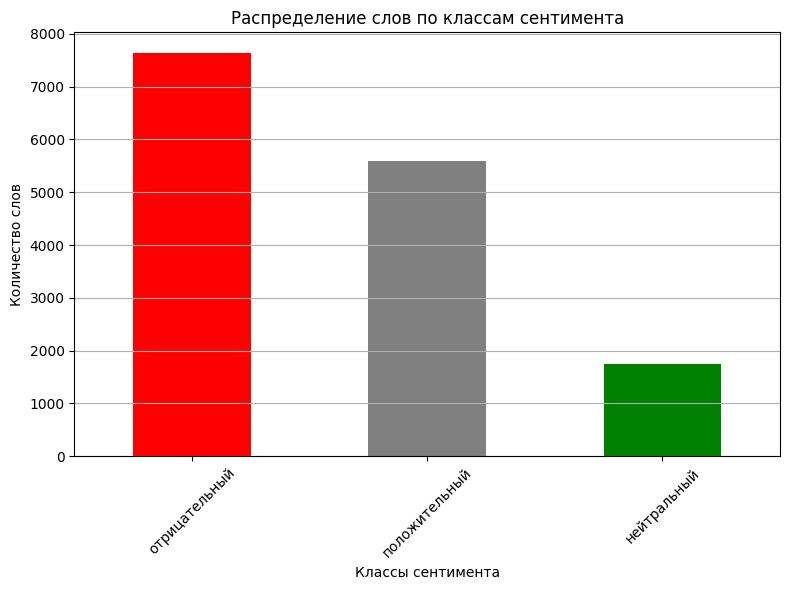

In [80]:
import matplotlib.pyplot as plt

# Построение диаграммы
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Распределение слов по классам сентимента')
plt.xlabel('Классы сентимента')
plt.ylabel('Количество слов')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Показать диаграмму
plt.tight_layout()
plt.show()

In [85]:
# Определение минимального количества слов в классе

class_counts = merged_df['sentiment'].value_counts()
min_count = class_counts.min()

# Создание синтетического датасета
synthetic_data = []

for sentiment in class_counts.index:
    # Выбор случайных строк для каждого класса
    sampled_data = merged_df[merged_df['sentiment'] == sentiment].sample(min_count, random_state=1)
    synthetic_data.append(sampled_data)

# Объединение выбранных данных
synthetic_dataset = pd.concat(synthetic_data, ignore_index=True)

# Сохранение синтетического датасета в CSV файл
synthetic_dataset.to_csv('/content/synthetic_sentiment_vocabulary.csv', index=False, encoding='utf-8')



In [86]:
print(synthetic_dataset.value_counts)

<bound method DataFrame.value_counts of                 word      sentiment
0         навязчивый  отрицательный
1          неприязни  отрицательный
2             злость  отрицательный
3           трахнуть  отрицательный
4           неоплата  отрицательный
...              ...            ...
5260  неопределенная    нейтральный
5261      осуждающий    нейтральный
5262        повороты    нейтральный
5263           галлы    нейтральный
5264     перерасчета    нейтральный

[5265 rows x 2 columns]>


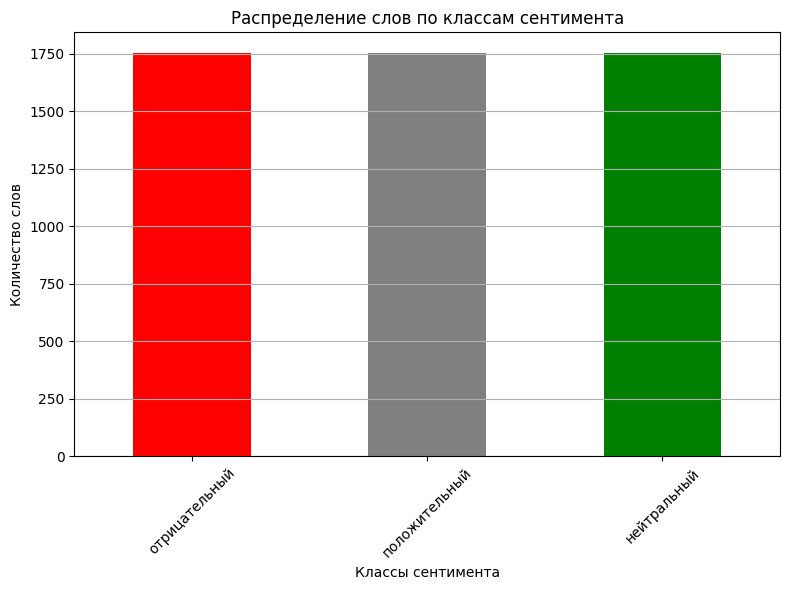

In [89]:
new_class_distribution = synthetic_dataset['sentiment'].value_counts()

# Построение диаграммы
plt.figure(figsize=(8, 6))
new_class_distribution.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Распределение слов по классам сентимента')
plt.xlabel('Классы сентимента')
plt.ylabel('Количество слов')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Показать диаграмму
plt.tight_layout()
plt.show()